In [9]:
# data analysis by Yash Vardhan

import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
%matplotlib inline


In [10]:
df = pd.read_excel('ECG.xlsx')

In [11]:
df.drop(['_id', 'pet_id'], axis = 1, inplace = True)
df.head()

,ecg_path,duration,breeds,weight,age,segments_br,segments_hr,ecg_pulses,bad_ecg
0,ecg_data/62271dc2b9baee839b0c1e99.wav,300.12,boxer,34.0,4.5,"[{'deb': 200.0, 'fin': 240.0, 'value': 13.24}]",NaN,"[0.98, 2.51, 2.82, 3.39, 4.04, 4.65, 5.57, 6.5...","[(2.0, 132.0), (184.0, 298.1231)]"
1,ecg_data/62271ea0be903091edb2bf09.wav,300.08,boxer,34.0,4.5,"[{'deb': 240.0, 'fin': 280.0, 'value': 12.34},...",NaN,"[0.64, 1.28, 2.06, 2.37, 2.79, 3.7, 4.41, 5.3,...","[(2.0, 298.0769)]"
2,ecg_data/622723bebe903091edb2bf0b.wav,300.08,boxer,34.0,4.5,"[{'deb': 210.0, 'fin': 250.0, 'value': 12.01},...","[{'deb': 90.0, 'fin': 110.0, 'value': 56.39}, ...","[0.93, 1.14, 1.94, 2.95, 3.82, 4.44, 5.02, 6.3...","[(2.0, 80.0), (132.0, 158.0)]"
3,ecg_data/622776fabe903091edb2bf0d.wav,300.14,boxer,34.0,4.5,"[{'deb': 50.0, 'fin': 90.0, 'value': 13.13}]","[{'deb': 240.0, 'fin': 260.0, 'value': 52.43},...","[0.83, 1.84, 2.62, 3.33, 5.25, 6.9, 7.77, 8.43...","[(28.0, 106.0), (158.0, 210.0), (262.0, 298.14..."
4,ecg_data/622799e5ea79f8f9cc02b284.wav,300.12,boxer,34.0,4.5,"[{'deb': 100.0, 'fin': 140.0, 'value': 13.99}]","[{'deb': 250.0, 'fin': 270.0, 'value': 46.81},...","[1.18, 2.33, 3.75, 5.42, 6.6, 7.76, 8.84, 9.94...","[(28.0, 236.0)]"


In [12]:
import numpy as np
import scipy.io.wavfile as wav
import ast

def load_clipped_wav_from_pulses(path, pulse_str):
    try:
        # Safely convert string to list
        pulse_times = ast.literal_eval(pulse_str) if isinstance(pulse_str, str) else pulse_str

        # Handle empty or invalid lists
        if not isinstance(pulse_times, list) or len(pulse_times) < 2:
            return np.nan

        sr, data = wav.read(path)
        if data.ndim > 1:
            data = data[:, 0]  # Mono

        segments = [(pulse_times[i], pulse_times[i + 1]) for i in range(0, len(pulse_times) - 1, 2)]
        clips = [data[int(start * sr):int(end * sr)] for start, end in segments if isinstance(start, (int, float)) and isinstance(end, (int, float))]
        return np.concatenate(clips) if clips else np.nan

    except Exception as e:
        print(f"Error reading {path}: {e}")
        return np.nan

# Apply function
df["ecg"] = df.apply(lambda row: load_clipped_wav_from_pulses(row["ecg_path"], row["ecg_pulses"]), axis=1)



In [13]:
import numpy as np
import scipy.io.wavfile as wav
import ast

def clip_bad_ecg_from_wav(path, bad_ecg_str):
    try:
        # Parse string to Python list
        if isinstance(bad_ecg_str, str):
            bad_ecg_times = ast.literal_eval(bad_ecg_str)
        else:
            bad_ecg_times = bad_ecg_str  # already parsed

        if not isinstance(bad_ecg_times, list) or len(bad_ecg_times) == 0:
            return np.nan

        sr, data = wav.read(path)

        # Handle stereo: take only one channel
        if data.ndim > 1:
            data = data[:, 0]

        clips = []
        for segment in bad_ecg_times:
            if isinstance(segment, (list, tuple)) and len(segment) == 2:
                start, end = segment
                if isinstance(start, (int, float)) and isinstance(end, (int, float)):
                    start_idx = int(start * sr)
                    end_idx = int(end * sr)
                    if 0 <= start_idx < end_idx <= len(data):
                        clips.append(data[start_idx:end_idx])

        return np.concatenate(clips) if clips else np.nan

    except Exception as e:
        print(f"Error in clipping {path}: {e}")
        return np.nan

# Apply the clipping function to each row
df["bad_ecg_clip"] = df.apply(lambda row: clip_bad_ecg_from_wav(row["ecg_path"], row["bad_ecg"]), axis=1)


In [14]:
df.sample(20)

,ecg_path,duration,breeds,weight,age,segments_br,segments_hr,ecg_pulses,bad_ecg,ecg,bad_ecg_clip
800,ecg_data/6272a565fa7b5d98dea196bf.wav,300.17,cocker_anglais,15.4,2.5,"[{'deb': 90.0, 'fin': 130.0, 'value': 25.48}, ...","[{'deb': 120.0, 'fin': 140.0, 'value': 69.68},...","[0.98, 1.86, 2.45, 3.55, 4.2, 5.07, 5.69, 6.33...",[],"[303, 568, 81, -415, -107, 100, -107, -105, -4...",NaN
375,ecg_data/6227a4458cb091d84e475192.wav,300.08,labrador,25.5,3.5,"[{'deb': 160.0, 'fin': 200.0, 'value': 10.1}, ...","[{'deb': 10.0, 'fin': 30.0, 'value': 55.7}]","[0.83, 1.49, 3.05, 4.61, 5.3, 6.0, 7.67, 9.15,...","[(106.0, 132.0), (262.0, 298.0769)]","[-476, -1085, -570, 507, 221, -357, -89, 9, -1...","[-155, -170, -167, -179, -196, -204, -221, -24..."
400,ecg_data/6227a4c38cb091d84e47519f.wav,300.12,dalmatien,25.0,1.0,"[{'deb': 130.0, 'fin': 170.0, 'value': 13.92},...","[{'deb': 210.0, 'fin': 230.0, 'value': 64.43},...","[0.72, 1.33, 1.95, 2.85, 3.98, 4.91, 5.75, 6.3...","[(2.0, 28.0)]","[811, 1081, -442, -1131, -148, 107, -315, -165...","[-284, -7, -117, -191, -90, -102, -148, -122, ..."
87,ecg_data/62279bd7ea79f8f9cc02b2bb.wav,300.18,labrador,28.0,1.5,"[{'deb': 60.0, 'fin': 100.0, 'value': 12.94}, ...","[{'deb': 190.0, 'fin': 210.0, 'value': 67.73},...","[0.81, 1.78, 2.41, 3.18, 4.82, 5.85, 6.72, 7.3...",[],"[-1447, -485, 314, -53, -29, 193, 149, 91, 152...",NaN
457,ecg_data/6227a643ea79f8f9cc02b3e0.wav,300.09,beagle,9.3,4.5,"[{'deb': 40.0, 'fin': 80.0, 'value': 13.2}, {'...","[{'deb': 80.0, 'fin': 100.0, 'value': 69.62}, ...","[1.32, 2.68, 3.52, 4.12, 4.67, 6.0, 7.26, 7.98...",[],"[854, 1041, 87, -433, 82, 154, -147, -41, 58, ...",NaN
49,ecg_data/62279accea79f8f9cc02b29d.wav,300.49,leonberg,42.0,1.5,"[{'deb': 90.0, 'fin': 130.0, 'value': 10.98}]","[{'deb': 100.0, 'fin': 120.0, 'value': 52.77},...","[1.06, 2.83, 3.73, 4.41, 5.08, 6.65, 7.65, 8.3...","[(132.0, 184.0), (236.0, 298.4846)]","[-383, -521, 36, 316, -16, -84, 74, 14, -48, 0...","[-4, -4, -4, -4, -2, -2, -7, -4, -4, -4, -2, -..."
820,ecg_data/62692b11149d36d3170afcd1.wav,300.04,berger,10.5,4.0,"[{'deb': 40.0, 'fin': 80.0, 'value': 10.54}]","[{'deb': 270.0, 'fin': 290.0, 'value': 64.27},...","[1.63, 3.05, 3.71, 4.27, 5.75, 6.98, 7.58, 9.0...",[],"[731, 760, -9, -279, 79, 7, -166, -57, -21, -7...",NaN
723,ecg_data/6272a4f2f5a1d7d464875bb7.wav,300.17,cocker_anglais,15.4,2.5,"[{'deb': 90.0, 'fin': 130.0, 'value': 19.51}, ...","[{'deb': 90.0, 'fin': 110.0, 'value': 63.24}, ...","[0.85, 1.45, 2.62, 3.92, 4.73, 5.24, 5.83, 7.2...",[],"[-1232, -1038, 397, 554, -322, -62, 312, 4, -3...",NaN
1053,ecg_data/637ea60c7c92b247d59b0780.wav,334.46,samoyede,25.0,3.5,"[{'deb': 30.0, 'fin': 70.0, 'value': 21.82}, {...","[{'deb': 220.0, 'fin': 240.0, 'value': 43.48},...","[0.43, 1.2, 2.95, 4.82, 6.29, 8.05, 9.03, 10.6...",[],"[11191, 11521, 11387, 10981, 11122, 11246, 110...",NaN
118,ecg_data/62277a96a5ff2fba7b7faf03.wav,300.14,unknown,23.5,2.5,"[{'deb': 50.0, 'fin': 90.0, 'value': 17.33}, {...","[{'deb': 10.0, 'fin': 30.0, 'value': 73.45}, {...","[0.69, 1.92, 2.45, 3.06, 4.32, 5.05, 5.58, 6.2...",[],"[82, 1522, 406, -546, 135, 217, -224, -74, 62,...",NaN


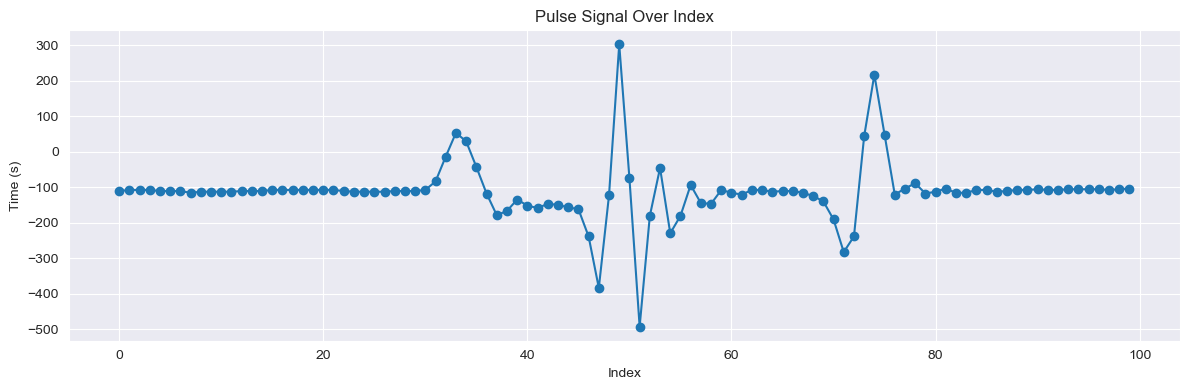

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Your array (shortened for readability here)
pulse_times = np.array([-111, -108, -108, -108, -111, -111, -111, -116, -113, -113, -113, -113, -111, -111, -111, -108, -108, -108, -108, -108, -108, -108, -111, -113, -113, -113, -113, -111, -111, -111, -108, -84, -14, 53, 29, -43, -118, -179, -167, -135, -152, -159, -147, -150, -157, -162, -239, -384, -123, 302, -75, -493, -181, -46, -230, -181, -94, -145, -147, -108, -116, -121, -108, -108, -113, -111, -111, -116, -125, -140, -191, -283, -239, 43, 217, 48, -121, -104, -89, -118, -113, -104, -116, -116, -108, -108, -113, -111, -108, -108, -106, -108, -108, -106, -106, -106, -106, -108, -106, -104])

plt.figure(figsize=(12, 4))
plt.plot(pulse_times, marker='o')
plt.title("Pulse Signal Over Index")
plt.xlabel("Index")
plt.ylabel("Time (s)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
def extract_value_from_string(s):
    if isinstance(s, str):
        match = re.search(r"'value'\s*:\s*([\d.]+)", s)
        if match:
            return float(match.group(1))
    return None

df['breathing_rate'] = df['segments_br'].apply(extract_value_from_string)
df['heart_rate'] = df['segments_hr'].apply(extract_value_from_string)

In [17]:
df.head()

,ecg_path,duration,breeds,weight,age,segments_br,segments_hr,ecg_pulses,bad_ecg,ecg,bad_ecg_clip,breathing_rate,heart_rate
0,ecg_data/62271dc2b9baee839b0c1e99.wav,300.12,boxer,34.0,4.5,"[{'deb': 200.0, 'fin': 240.0, 'value': 13.24}]",NaN,"[0.98, 2.51, 2.82, 3.39, 4.04, 4.65, 5.57, 6.5...","[(2.0, 132.0), (184.0, 298.1231)]","[-77, -347, 82, 929, 1004, 666, 725, 781, 669,...","[-815, -817, -841, -856, -839, -834, -866, -89...",13.24,NaN
1,ecg_data/62271ea0be903091edb2bf09.wav,300.08,boxer,34.0,4.5,"[{'deb': 240.0, 'fin': 280.0, 'value': 12.34},...",NaN,"[0.64, 1.28, 2.06, 2.37, 2.79, 3.7, 4.41, 5.3,...","[(2.0, 298.0769)]","[184, 150, 299, 455, 408, 352, 360, 352, 403, ...","[172, 165, 267, 289, 221, 226, 250, 163, 92, 2...",12.34,NaN
2,ecg_data/622723bebe903091edb2bf0b.wav,300.08,boxer,34.0,4.5,"[{'deb': 210.0, 'fin': 250.0, 'value': 12.01},...","[{'deb': 90.0, 'fin': 110.0, 'value': 56.39}, ...","[0.93, 1.14, 1.94, 2.95, 3.82, 4.44, 5.02, 6.3...","[(2.0, 80.0), (132.0, 158.0)]","[17, 68, 114, 121, 107, 90, 77, 65, 60, 63, 55...","[19, 41, 12, 9, -14, -85, -145, -167, -167, -1...",12.01,56.39
3,ecg_data/622776fabe903091edb2bf0d.wav,300.14,boxer,34.0,4.5,"[{'deb': 50.0, 'fin': 90.0, 'value': 13.13}]","[{'deb': 240.0, 'fin': 260.0, 'value': 52.43},...","[0.83, 1.84, 2.62, 3.33, 5.25, 6.9, 7.77, 8.43...","[(28.0, 106.0), (158.0, 210.0), (262.0, 298.14...","[-445, -678, -379, 245, 163, -158, -19, 60, -5...","[114, -63, -321, -506, -167, 423, 333, 36, 163...",13.13,52.43
4,ecg_data/622799e5ea79f8f9cc02b284.wav,300.12,boxer,34.0,4.5,"[{'deb': 100.0, 'fin': 140.0, 'value': 13.99}]","[{'deb': 250.0, 'fin': 270.0, 'value': 46.81},...","[1.18, 2.33, 3.75, 5.42, 6.6, 7.76, 8.84, 9.94...","[(28.0, 236.0)]","[-691, -1167, -790, 199, 510, 21, -109, 94, 17...","[85, 92, 107, 102, 92, 99, 102, 97, 90, 48, -2...",13.99,46.81


In [18]:
df.drop(['segments_br', 'segments_hr'], axis = 1, inplace = True)

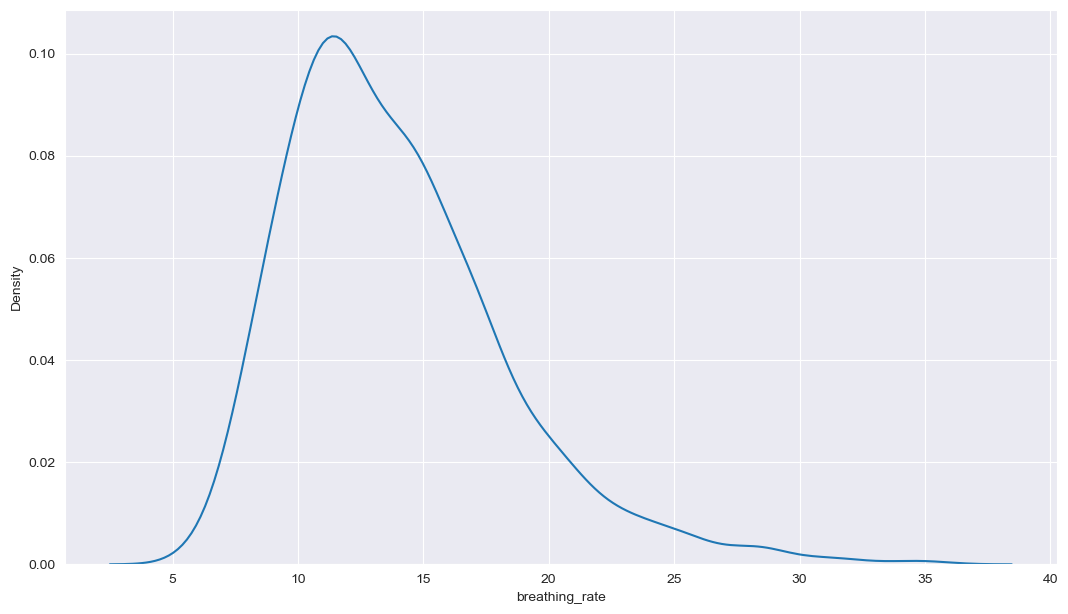

In [19]:
sns.kdeplot(df['breathing_rate'])
plt.gcf().set_size_inches(12.8, 7.2)
plt.show()

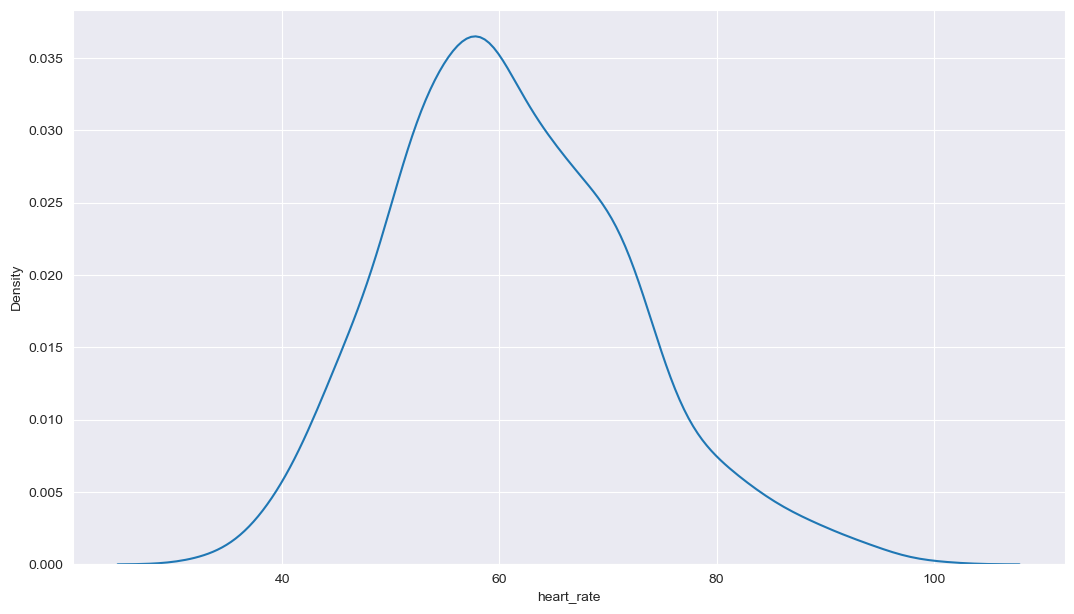

In [20]:
sns.kdeplot(df['heart_rate'])
plt.gcf().set_size_inches(12.8, 7.2)
plt.show()

In [21]:
df.breathing_rate.fillna(df.breathing_rate.mean(), inplace = True)
df.heart_rate.fillna(df.heart_rate.mean(), inplace = True)

/var/folders/t9/g5x_d7z527d211lqjn5843q80000gn/T/ipykernel_4141/4087427893.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.breathing_rate.fillna(df.breathing_rate.mean(), inplace = True)
/var/folders/t9/g5x_d7z527d211lqjn5843q80000gn/T/ipykernel_4141/4087427893.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are set

In [22]:
df.head()

,ecg_path,duration,breeds,weight,age,ecg_pulses,bad_ecg,ecg,bad_ecg_clip,breathing_rate,heart_rate
0,ecg_data/62271dc2b9baee839b0c1e99.wav,300.12,boxer,34.0,4.5,"[0.98, 2.51, 2.82, 3.39, 4.04, 4.65, 5.57, 6.5...","[(2.0, 132.0), (184.0, 298.1231)]","[-77, -347, 82, 929, 1004, 666, 725, 781, 669,...","[-815, -817, -841, -856, -839, -834, -866, -89...",13.24,61.067087
1,ecg_data/62271ea0be903091edb2bf09.wav,300.08,boxer,34.0,4.5,"[0.64, 1.28, 2.06, 2.37, 2.79, 3.7, 4.41, 5.3,...","[(2.0, 298.0769)]","[184, 150, 299, 455, 408, 352, 360, 352, 403, ...","[172, 165, 267, 289, 221, 226, 250, 163, 92, 2...",12.34,61.067087
2,ecg_data/622723bebe903091edb2bf0b.wav,300.08,boxer,34.0,4.5,"[0.93, 1.14, 1.94, 2.95, 3.82, 4.44, 5.02, 6.3...","[(2.0, 80.0), (132.0, 158.0)]","[17, 68, 114, 121, 107, 90, 77, 65, 60, 63, 55...","[19, 41, 12, 9, -14, -85, -145, -167, -167, -1...",12.01,56.390000
3,ecg_data/622776fabe903091edb2bf0d.wav,300.14,boxer,34.0,4.5,"[0.83, 1.84, 2.62, 3.33, 5.25, 6.9, 7.77, 8.43...","[(28.0, 106.0), (158.0, 210.0), (262.0, 298.14...","[-445, -678, -379, 245, 163, -158, -19, 60, -5...","[114, -63, -321, -506, -167, 423, 333, 36, 163...",13.13,52.430000
4,ecg_data/622799e5ea79f8f9cc02b284.wav,300.12,boxer,34.0,4.5,"[1.18, 2.33, 3.75, 5.42, 6.6, 7.76, 8.84, 9.94...","[(28.0, 236.0)]","[-691, -1167, -790, 199, 510, 21, -109, 94, 17...","[85, 92, 107, 102, 92, 99, 102, 97, 90, 48, -2...",13.99,46.810000


In [23]:
encoder = LabelEncoder()
df['breeds'] = encoder.fit_transform(df['breeds'])
df.sample(20)


,ecg_path,duration,breeds,weight,age,ecg_pulses,bad_ecg,ecg,bad_ecg_clip,breathing_rate,heart_rate
997,NaN,574.54,23,27.0,5.5,NaN,[],NaN,NaN,14.470000,61.067087
478,ecg_data/6227a6998cb091d84e4751d3.wav,160.79,2,9.3,4.5,"[2.03, 3.31, 3.81, 4.28, 4.74, 6.02, 7.12, 8.0...",[],"[924, 1442, -38, -641, 179, 58, -324, -79, -7,...",NaN,11.710000,52.240000
970,ecg_data/625930b94a9b1217fd236b4f.wav,300.18,21,24.8,2.0,"[0.93, 2.13, 3.08, 3.79, 4.43, 5.53, 6.89, 7.9...",[],"[584, 750, 225, -165, 35, 23, -141, -88, -52, ...",NaN,8.930000,51.110000
937,ecg_data/625849654a9b1217fd236b32.wav,300.17,22,17.5,2.0,"[0.62, 1.76, 3.17, 4.58, 5.48, 6.2, 6.74, 7.25...",[],"[-1305, -33, 242, -245, -72, 108, -52, -55, 31...",NaN,7.000000,56.710000
922,ecg_data/625848bfe0539383be611d29.wav,300.14,22,17.5,2.0,"[1.42, 2.01, 2.56, 3.7, 5.02, 6.1, 7.01, 7.58,...",[],"[-163, -1404, -1026, 247, 67, -329, 31, 81, -1...",NaN,11.930000,67.540000
438,ecg_data/6227a5968cb091d84e4751b6.wav,300.18,2,9.3,4.5,"[0.8, 2.18, 3.35, 3.93, 5.29, 6.35, 6.94, 8.12...",[],"[5320, 4422, 2733, 2972, 3518, 3008, 2890, 313...",NaN,15.390000,53.350000
840,ecg_data/6258452de0539383be611ce9.wav,300.14,0,20.0,9.5,"[0.95, 1.68, 3.01, 3.67, 5.01, 5.62, 6.93, 7.5...","[(158.0, 184.0)]","[7, 628, 402, -586, -542, -39, -230, -368, -18...","[-122, -132, -127, -127, -130, -122, -127, -12...",26.500000,56.600000
1122,ecg_data/637eba7df719971700a29775.wav,321.51,18,25.0,3.5,"[0.52, 1.72, 3.36, 4.3, 4.95, 6.41, 7.82, 8.47...",[],"[11665, 11859, 10774, 10106, 10419, 10363, 101...",NaN,13.903283,45.300000
334,ecg_data/62583743e0539383be611c64.wav,300.13,10,33.0,1.5,"[1.56, 2.28, 2.9, 3.45, 4.15, 5.17, 5.87, 6.48...",[],"[7, -64, -102, 21, 143, 71, 9, 59, 64, 33, 43,...",NaN,11.490000,81.660000
361,ecg_data/62277c54aea43ef3b260d737.wav,300.36,3,38.0,4.0,"[1.27, 1.98, 2.62, 3.22, 5.61, 7.91, 8.31, 9.2...",[],"[4077, 3839, 2825, 2885, 2735, 1060, -794, -14...",NaN,7.300000,43.200000


In [24]:
df['bad_ecg'] = df['bad_ecg'].apply(lambda x: np.nan if x == [] or x == '[]' else x)

In [25]:
df.head(10)

,ecg_path,duration,breeds,weight,age,ecg_pulses,bad_ecg,ecg,bad_ecg_clip,breathing_rate,heart_rate
0,ecg_data/62271dc2b9baee839b0c1e99.wav,300.12,6,34.0,4.5,"[0.98, 2.51, 2.82, 3.39, 4.04, 4.65, 5.57, 6.5...","[(2.0, 132.0), (184.0, 298.1231)]","[-77, -347, 82, 929, 1004, 666, 725, 781, 669,...","[-815, -817, -841, -856, -839, -834, -866, -89...",13.24,61.067087
1,ecg_data/62271ea0be903091edb2bf09.wav,300.08,6,34.0,4.5,"[0.64, 1.28, 2.06, 2.37, 2.79, 3.7, 4.41, 5.3,...","[(2.0, 298.0769)]","[184, 150, 299, 455, 408, 352, 360, 352, 403, ...","[172, 165, 267, 289, 221, 226, 250, 163, 92, 2...",12.34,61.067087
2,ecg_data/622723bebe903091edb2bf0b.wav,300.08,6,34.0,4.5,"[0.93, 1.14, 1.94, 2.95, 3.82, 4.44, 5.02, 6.3...","[(2.0, 80.0), (132.0, 158.0)]","[17, 68, 114, 121, 107, 90, 77, 65, 60, 63, 55...","[19, 41, 12, 9, -14, -85, -145, -167, -167, -1...",12.01,56.390000
3,ecg_data/622776fabe903091edb2bf0d.wav,300.14,6,34.0,4.5,"[0.83, 1.84, 2.62, 3.33, 5.25, 6.9, 7.77, 8.43...","[(28.0, 106.0), (158.0, 210.0), (262.0, 298.14...","[-445, -678, -379, 245, 163, -158, -19, 60, -5...","[114, -63, -321, -506, -167, 423, 333, 36, 163...",13.13,52.430000
4,ecg_data/622799e5ea79f8f9cc02b284.wav,300.12,6,34.0,4.5,"[1.18, 2.33, 3.75, 5.42, 6.6, 7.76, 8.84, 9.94...","[(28.0, 236.0)]","[-691, -1167, -790, 199, 510, 21, -109, 94, 17...","[85, 92, 107, 102, 92, 99, 102, 97, 90, 48, -2...",13.99,46.810000
5,ecg_data/622799e58cb091d84e475072.wav,300.17,6,34.0,4.5,"[2.36, 3.74, 4.35, 4.92, 6.75, 8.45, 9.05, 10....","[(28.0, 54.0), (106.0, 132.0), (184.0, 236.0)]","[-630, -1136, -727, 299, 559, 48, -60, 126, 41...","[-17, -17, -21, -29, -38, -51, -53, -46, -24, ...",9.67,46.570000
6,ecg_data/622799eeea79f8f9cc02b285.wav,300.08,6,34.0,4.5,"[0.88, 1.95, 2.85, 3.44, 3.98, 4.52, 5.68, 7.2...",NaN,"[-1099, -437, 501, 440, -77, -58, 75, -53, -85...",NaN,14.50,49.840000
7,ecg_data/6227774bb9baee839b0c1e9c.wav,300.14,6,34.0,4.5,"[1.09, 1.83, 2.46, 4.26, 5.82, 6.69, 7.4, 9.32...","[(210.0, 236.0), (262.0, 298.1462)]","[-1048, -1267, -211, 686, 328, -138, 7, 60, -9...","[-17, -19, -24, -24, -24, -29, -31, -31, -31, ...",15.12,52.350000
8,ecg_data/622799ec8cb091d84e475073.wav,300.12,6,34.0,4.5,"[1.04, 1.98, 3.02, 3.31, 3.77, 4.95, 6.01, 6.4...","[(2.0, 28.0), (54.0, 106.0)]","[-576, -257, 299, 148, -165, 4, 94, -9, -17, 2...","[141, 116, 148, 177, 177, 184, 172, 153, 133, ...",15.58,57.180000
9,ecg_data/622799f58cb091d84e475074.wav,300.17,6,34.0,4.5,"[1.05, 2.66, 3.43, 4.04, 4.77, 6.65, 8.08, 9.1...",NaN,"[-547, -525, -109, 216, 55, -138, -36, 0, -72,...",NaN,9.84,56.450000


In [26]:
from sklearn.utils import resample

# Separate bad and good ECGs
bad_ecg_df = df[df["bad_ecg"].notna()]
good_ecg_df = df[df["bad_ecg"].isna()]

# Upsample bad ECGs to match good ECG count (or any ratio you want)
bad_ecg_upsampled = resample(
    bad_ecg_df,
    replace=True,
    n_samples=len(good_ecg_df),
    random_state=42
)

# Combine with original DataFrame
df = pd.concat([good_ecg_df, bad_ecg_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

In [27]:
df.head(10)

,ecg_path,duration,breeds,weight,age,ecg_pulses,bad_ecg,ecg,bad_ecg_clip,breathing_rate,heart_rate
0,ecg_data/6227a6adea79f8f9cc02b3ec.wav,300.12,2,10.0,4.5,"[1.39, 2.23, 2.83, 3.35, 3.95, 5.07, 6.1, 6.93...",NaN,"[-56, 620, 883, -205, -673, -2, 39, -268, -134...",NaN,12.370000,76.380000
1,ecg_data/625836d2e0539383be611c5e.wav,300.14,10,33.0,1.5,"[28.37, 28.96, 30.01, 30.77, 31.52, 32.34, 33....","[(2.0, 298.1462)]","[50, 52, 28, 11, 28, 59, 71, 66, 83, 114, 124,...","[2526, 2505, 2483, 2459, 2435, 2414, 2390, 236...",14.800000,61.067087
2,ecg_data/625931974a9b1217fd236b62.wav,300.14,21,24.8,2.0,"[0.88, 2.22, 3.17, 3.75, 4.3, 4.85, 6.28, 7.52...",NaN,"[-445, 1217, 1327, -244, -374, 207, -122, -298...",NaN,9.220000,94.400000
3,ecg_data/62583cc04a9b1217fd236a93.wav,300.09,1,16.0,2.5,"[1.16, 2.24, 3.03, 3.62, 4.6, 5.51, 6.52, 7.14...",NaN,"[1040, 2782, 1149, -597, 19, 226, -346, -238, ...",NaN,20.880000,67.500000
4,ecg_data/625930c8e0539383be611d56.wav,300.18,21,24.8,2.0,"[1.05, 1.64, 2.95, 4.15, 4.8, 5.38, 5.98, 7.22...","[(132.0, 158.0)]","[841, 244, -210, 43, 40, -146, -98, -33, -79, ...","[122, 325, 606, 448, -55, -74, 45, -93, -122, ...",13.903283,70.250000
5,ecg_data/6227a6e7ea79f8f9cc02b3f2.wav,300.17,2,10.0,4.5,"[1.31, 2.22, 2.92, 3.67, 4.23, 5.42, 6.6, 7.52...","[(2.0, 28.0), (184.0, 236.0)]","[986, 305, -673, -124, 190, -236, -190, -36, -...","[-100, -107, -83, -109, -95, -92, -112, -83, -...",10.420000,71.290000
6,ecg_data/626a89a7149d36d3170afd0b.wav,300.09,4,11.0,5.5,"[1.0, 1.62, 2.98, 4.06, 4.65, 5.98, 7.01, 7.88...",NaN,"[1016, -245, -440, 110, -91, -327, -144, -139,...",NaN,19.760000,63.390000
7,ecg_data/626a88841c86b9451c61b62b.wav,300.13,4,11.0,5.5,"[1.05, 2.48, 4.43, 6.82, 9.11, 11.46, 12.77, 1...","[(28.0, 54.0)]","[7419, 7980, 7958, 6920, 6703, 7149, 6870, 660...","[-79, -79, -84, -81, -81, -81, -79, -77, -77, ...",14.220000,47.460000
8,ecg_data/625848df4a9b1217fd236b27.wav,300.17,22,17.5,2.0,"[1.45, 2.03, 2.6, 3.85, 5.22, 6.23, 7.25, 8.05...",NaN,"[-1589, -440, 375, -199, -216, 132, -14, -105,...",NaN,11.060000,61.150000
9,ecg_data/62279e2e8cb091d84e4750e9.wav,300.17,16,25.5,3.5,"[2.96, 5.2, 6.96, 8.49, 10.07, 11.2, 11.85, 12...",NaN,"[694, 668, -215, -382, -4, -104, -230, -106, -...",NaN,7.780000,49.900000


In [28]:
df

,ecg_path,duration,breeds,weight,age,ecg_pulses,bad_ecg,ecg,bad_ecg_clip,breathing_rate,heart_rate
0,ecg_data/6227a6adea79f8f9cc02b3ec.wav,300.12,2,10.0,4.5,"[1.39, 2.23, 2.83, 3.35, 3.95, 5.07, 6.1, 6.93...",NaN,"[-56, 620, 883, -205, -673, -2, 39, -268, -134...",NaN,12.370000,76.380000
1,ecg_data/625836d2e0539383be611c5e.wav,300.14,10,33.0,1.5,"[28.37, 28.96, 30.01, 30.77, 31.52, 32.34, 33....","[(2.0, 298.1462)]","[50, 52, 28, 11, 28, 59, 71, 66, 83, 114, 124,...","[2526, 2505, 2483, 2459, 2435, 2414, 2390, 236...",14.800000,61.067087
2,ecg_data/625931974a9b1217fd236b62.wav,300.14,21,24.8,2.0,"[0.88, 2.22, 3.17, 3.75, 4.3, 4.85, 6.28, 7.52...",NaN,"[-445, 1217, 1327, -244, -374, 207, -122, -298...",NaN,9.220000,94.400000
3,ecg_data/62583cc04a9b1217fd236a93.wav,300.09,1,16.0,2.5,"[1.16, 2.24, 3.03, 3.62, 4.6, 5.51, 6.52, 7.14...",NaN,"[1040, 2782, 1149, -597, 19, 226, -346, -238, ...",NaN,20.880000,67.500000
4,ecg_data/625930c8e0539383be611d56.wav,300.18,21,24.8,2.0,"[1.05, 1.64, 2.95, 4.15, 4.8, 5.38, 5.98, 7.22...","[(132.0, 158.0)]","[841, 244, -210, 43, 40, -146, -98, -33, -79, ...","[122, 325, 606, 448, -55, -74, 45, -93, -122, ...",13.903283,70.250000
...,...,...,...,...,...,...,...,...,...,...,...
1345,ecg_data/6272a556fa7b5d98dea196be.wav,300.12,8,15.4,2.5,"[0.98, 1.64, 2.82, 3.92, 4.45, 4.96, 6.29, 7.2...","[(2.0, 28.0)]","[16, 234, 179, -186, -219, -9, -40, -117, -66,...","[-74, -71, -71, -74, -78, -83, -78, -76, -76, ...",28.060000,71.790000
1346,ecg_data/62277d85aea43ef3b260d768.wav,300.14,0,26.0,2.0,"[1.53, 2.38, 3.02, 3.58, 4.44, 5.36, 6.29, 6.8...","[(158.0, 210.0)]","[-211, -204, 12, 69, -7, -9, 4, -4, -4, 7, 9, ...","[-105, -101, -101, -96, -96, -96, -96, -101, -...",20.050000,68.460000
1347,ecg_data/637ebc37f719971700a29776.wav,314.86,18,25.0,3.5,"[0.54, 1.88, 4.12, 4.97, 5.58, 7.48, 8.96, 10....","[(2.0, 312.8538)]","[10641, 10512, 10403, 10451, 10398, 10262, 102...","[1889, 1687, 1899, 1914, 1763, 1816, 1871, 182...",9.500000,61.067087
1348,ecg_data/62584477e0539383be611ce1.wav,300.09,7,27.0,2.5,"[1.05, 2.26, 2.88, 3.46, 4.95, 6.49, 7.84, 8.4...","[(2.0, 298.0769)]","[-452, -146, 339, 514, 372, 238, 170, 108, 86,...","[2, -7, -4, -2, -9, -14, -31, 26, 67, -329, -5...",9.610000,61.067087


In [29]:
df.rename(columns = {'duration' : 'duration (seconds)', 'weight' : 'weight (Kg)', 'age' : 'age (years)', 'breathing_rate' : 'breathing_rate (BPM)', 'heart_rate' : 'heart_rate (BPM)'}, inplace = True)

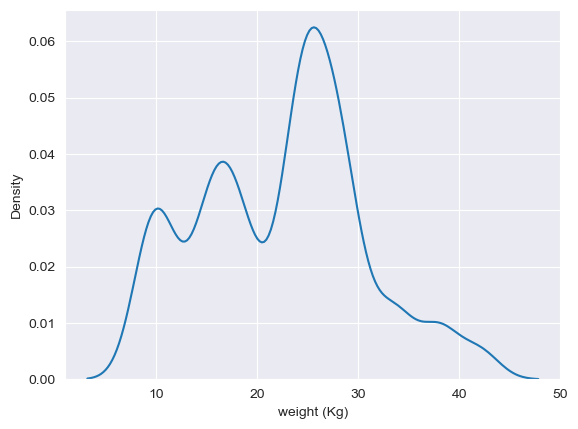

In [30]:
sns.kdeplot(df["weight (Kg)"])
plt.show()

In [31]:
df.drop(df.columns[2], axis =1, inplace = True )

In [32]:
df.insert(3, "Resting Energy Requirement(Kcal/day)", 70 * (df['weight (Kg)'] ** 0.75))

In [33]:
df["Canine Vital Index"] = (df["heart_rate (BPM)"] * df["breathing_rate (BPM)"]) / (df["weight (Kg)"] * 101.1) * 100

In [34]:
df.rename(columns = {"Canine Vital Index" : "Canine Vital Index (at 101.1°F)"}, inplace = True)

In [35]:
df["Canine Vital Index (at 101.3°F)"] = (df["heart_rate (BPM)"] * df["breathing_rate (BPM)"]) / (df["weight (Kg)"] * 101.3) * 100

In [36]:
df["Canine Vital Index (at 101.5°F)"] = (df["heart_rate (BPM)"] * df["breathing_rate (BPM)"]) / (df["weight (Kg)"] * 101.5) * 100

In [37]:
df

,ecg_path,duration (seconds),weight (Kg),Resting Energy Requirement(Kcal/day),age (years),ecg_pulses,bad_ecg,ecg,bad_ecg_clip,breathing_rate (BPM),heart_rate (BPM),Canine Vital Index (at 101.1°F),Canine Vital Index (at 101.3°F),Canine Vital Index (at 101.5°F)
0,ecg_data/6227a6adea79f8f9cc02b3ec.wav,300.12,10.0,393.638928,4.5,"[1.39, 2.23, 2.83, 3.35, 3.95, 5.07, 6.1, 6.93...",NaN,"[-56, 620, 883, -205, -673, -2, 39, -268, -134...",NaN,12.370000,76.380000,93.454065,93.269556,93.085773
1,ecg_data/625836d2e0539383be611c5e.wav,300.14,33.0,963.792395,1.5,"[28.37, 28.96, 30.01, 30.77, 31.52, 32.34, 33....","[(2.0, 298.1462)]","[50, 52, 28, 11, 28, 59, 71, 66, 83, 114, 124,...","[2526, 2505, 2483, 2459, 2435, 2414, 2390, 236...",14.800000,61.067087,27.089677,27.036193,26.982919
2,ecg_data/625931974a9b1217fd236b62.wav,300.14,24.8,777.923338,2.0,"[0.88, 2.22, 3.17, 3.75, 4.3, 4.85, 6.28, 7.52...",NaN,"[-445, 1217, 1327, -244, -374, 207, -122, -298...",NaN,9.220000,94.400000,34.713634,34.645098,34.576831
3,ecg_data/62583cc04a9b1217fd236a93.wav,300.09,16.0,560.000000,2.5,"[1.16, 2.24, 3.03, 3.62, 4.6, 5.51, 6.52, 7.14...",NaN,"[1040, 2782, 1149, -597, 19, 226, -346, -238, ...",NaN,20.880000,67.500000,87.129080,86.957058,86.785714
4,ecg_data/625930c8e0539383be611d56.wav,300.18,24.8,777.923338,2.0,"[1.05, 1.64, 2.95, 4.15, 4.8, 5.38, 5.98, 7.22...","[(132.0, 158.0)]","[841, 244, -210, 43, 40, -146, -98, -33, -79, ...","[122, 325, 606, 448, -55, -74, 45, -93, -122, ...",13.903283,70.250000,38.954789,38.877880,38.801273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,ecg_data/6272a556fa7b5d98dea196be.wav,300.12,15.4,544.174993,2.5,"[0.98, 1.64, 2.82, 3.92, 4.45, 4.96, 6.29, 7.2...","[(2.0, 28.0)]","[16, 234, 179, -186, -219, -9, -40, -117, -66,...","[-74, -71, -71, -74, -78, -83, -78, -76, -76, ...",28.060000,71.790000,129.383753,129.128306,128.873866
1346,ecg_data/62277d85aea43ef3b260d768.wav,300.14,26.0,805.987026,2.0,"[1.53, 2.38, 3.02, 3.58, 4.44, 5.36, 6.29, 6.8...","[(158.0, 210.0)]","[-211, -204, 12, 69, -7, -9, 4, -4, -4, 7, 9, ...","[-105, -101, -101, -96, -96, -96, -96, -101, -...",20.050000,68.460000,52.218786,52.115688,52.012997
1347,ecg_data/637ebc37f719971700a29776.wav,314.86,25.0,782.623792,3.5,"[0.54, 1.88, 4.12, 4.97, 5.58, 7.48, 8.96, 10....","[(2.0, 312.8538)]","[10641, 10512, 10403, 10451, 10398, 10262, 102...","[1889, 1687, 1899, 1914, 1763, 1816, 1871, 182...",9.500000,61.067087,22.953010,22.907693,22.862555
1348,ecg_data/62584477e0539383be611ce1.wav,300.09,27.0,829.126628,2.5,"[1.05, 2.26, 2.88, 3.46, 4.95, 6.49, 7.84, 8.4...","[(2.0, 298.0769)]","[-452, -146, 339, 514, 372, 238, 170, 108, 86,...","[2, -7, -4, -2, -9, -14, -31, 26, 67, -329, -5...",9.610000,61.067087,21.498872,21.456426,21.414147


In [38]:
df.to_csv("updated_dataset_iter2.csv", index = False)


In [50]:
df.head()

,ecg_path,duration (seconds),weight (Kg),Resting Energy Requirement(Kcal/day),age (years),ecg_pulses,bad_ecg,ecg,bad_ecg_clip,breathing_rate (BPM),heart_rate (BPM),Canine Vital Index (at 101.1°F),Canine Vital Index (at 101.3°F),Canine Vital Index (at 101.5°F)
0,ecg_data/6227a6adea79f8f9cc02b3ec.wav,300.12,10.0,393.638928,4.5,"[1.39, 2.23, 2.83, 3.35, 3.95, 5.07, 6.1, 6.93...",NaN,"[-56, 620, 883, -205, -673, -2, 39, -268, -134...",NaN,12.370000,76.380000,93.454065,93.269556,93.085773
1,ecg_data/625836d2e0539383be611c5e.wav,300.14,33.0,963.792395,1.5,"[28.37, 28.96, 30.01, 30.77, 31.52, 32.34, 33....","[(2.0, 298.1462)]","[50, 52, 28, 11, 28, 59, 71, 66, 83, 114, 124,...","[2526, 2505, 2483, 2459, 2435, 2414, 2390, 236...",14.800000,61.067087,27.089677,27.036193,26.982919
2,ecg_data/625931974a9b1217fd236b62.wav,300.14,24.8,777.923338,2.0,"[0.88, 2.22, 3.17, 3.75, 4.3, 4.85, 6.28, 7.52...",NaN,"[-445, 1217, 1327, -244, -374, 207, -122, -298...",NaN,9.220000,94.400000,34.713634,34.645098,34.576831
3,ecg_data/62583cc04a9b1217fd236a93.wav,300.09,16.0,560.000000,2.5,"[1.16, 2.24, 3.03, 3.62, 4.6, 5.51, 6.52, 7.14...",NaN,"[1040, 2782, 1149, -597, 19, 226, -346, -238, ...",NaN,20.880000,67.500000,87.129080,86.957058,86.785714
4,ecg_data/625930c8e0539383be611d56.wav,300.18,24.8,777.923338,2.0,"[1.05, 1.64, 2.95, 4.15, 4.8, 5.38, 5.98, 7.22...","[(132.0, 158.0)]","[841, 244, -210, 43, 40, -146, -98, -33, -79, ...","[122, 325, 606, 448, -55, -74, 45, -93, -122, ...",13.903283,70.250000,38.954789,38.877880,38.801273


In [39]:
print(df.columns.tolist())

['ecg_path', 'duration (seconds)', 'weight (Kg)', 'Resting Energy Requirement(Kcal/day)', 'age (years)', 'ecg_pulses', 'bad_ecg', 'ecg', 'bad_ecg_clip', 'breathing_rate (BPM)', 'heart_rate (BPM)', 'Canine Vital Index (at 101.1°F)', 'Canine Vital Index (at 101.3°F)', 'Canine Vital Index (at 101.5°F)']


In [40]:
new_df = df[["ecg", "bad_ecg_clip"]].copy()

In [51]:
new_df.head()

,ecg,bad_ecg_clip
0,"[-56, 620, 883, -205, -673, -2, 39, -268, -134...",NaN
1,"[50, 52, 28, 11, 28, 59, 71, 66, 83, 114, 124,...","[2526, 2505, 2483, 2459, 2435, 2414, 2390, 236..."
2,"[-445, 1217, 1327, -244, -374, 207, -122, -298...",NaN
3,"[1040, 2782, 1149, -597, 19, 226, -346, -238, ...",NaN
4,"[841, 244, -210, 43, 40, -146, -98, -33, -79, ...","[122, 325, 606, 448, -55, -74, 45, -93, -122, ..."


In [54]:
new_df.to_csv("main_data_set.csv", index = False)

In [43]:
new_df["ecg"].isna().sum()

21

In [53]:
new_df.head()

,ecg,bad_ecg_clip
0,"[-56, 620, 883, -205, -673, -2, 39, -268, -134...",NaN
1,"[50, 52, 28, 11, 28, 59, 71, 66, 83, 114, 124,...","[2526, 2505, 2483, 2459, 2435, 2414, 2390, 236..."
2,"[-445, 1217, 1327, -244, -374, 207, -122, -298...",NaN
3,"[1040, 2782, 1149, -597, 19, 226, -346, -238, ...",NaN
4,"[841, 244, -210, 43, 40, -146, -98, -33, -79, ...","[122, 325, 606, 448, -55, -74, 45, -93, -122, ..."


In [44]:
new_df = new_df.dropna(subset=["ecg"])

In [45]:
new_df["ecg"].isna().sum()

0

In [46]:
new_df.to_csv("final_test_dataset.csv", index = False)

In [47]:
import pandas as pd
test = pd.read_csv("final_test_dataset.csv")

In [48]:
test.head()

,ecg,bad_ecg_clip
0,[ -56 620 883 ... -124 -153 31],NaN
1,[50 52 28 ... 33 21 14],[2526 2505 2483 ... -28 -28 -28]
2,[-445 1217 1327 ... -105 -564 -934],NaN
3,[1040 2782 1149 ... -192 -513 142],NaN
4,[ 841 244 -210 ... -112 -103 57],[122 325 606 ... 0 0 -2]
